# Trabalho de Conclusão de Curso II
**Aluno: Diogo de Paula Almazan** <br/>
**Engenharia de Sistemas - UFMG**<br/>
**Data: 2021/2**

## Bibliotecas

In [1]:
# Importação das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt

## Funções Úteis

In [2]:
def JoinMachineAndExecutionTime(vetor):
    resultado = []
    tamanho = len(vetor)
    i = 0
    while i < tamanho:
        resultado.append([vetor[i],vetor[i+1]])
        i = i + 2
    return resultado

def convertArrayToMatrix(data):
    dadosFormatados = []
    for item in data:
        dadosFormatados.append(JoinMachineAndExecutionTime(item.split()))
    return dadosFormatados

def compareFitnessAndReplaceOrNot(referentialFitness, currentFitness, currentVector, referentialVector):
    """
        Compare the currentFitness calculated and the referential fitness. If the currentFitness is smaller than the referential value, return current. If not, return the referential value.
    """
    if(currentFitness <= referentialFitness):
        return [currentFitness, currentVector]
    else:
        return [referentialFitness, referentialVector]

def generateRandomIterationNumber(numberOfIterations):
    return np.random.randint(numberOfIterations)

def copyArray(arrayToCopy):
    return arrayToCopy.copy()

## Leitura e formatação dos dados

In [3]:
def readInstanceAndReturnDataTaskMachines(fileWithDirectory):
    """
        Read the instance file and return data, besides the number of tasks and machines for the instance.
    """
    with open(fileWithDirectory) as file:
        lines = file.read()
        
    dimensions = lines.split('\n')[0]
    data = lines.split('\n')[1:]

    tasks = int(dimensions.split()[0])
    machines = int(dimensions.split()[1])
    print('Número de tasks: ', tasks)
    print('Número de máquinas: ', machines)
    return [data, tasks, machines]


# Format data and print
def formatReadData(data):
    """
        Format data to manipulate what is needed.
    """
    dadosFormatados = convertArrayToMatrix(data)
    # print(dadosFormatados)

    # Printa para ver o resultado
    # for i in range(0, len(dadosFormatados)):
    #     print("Tarefa {}: {}".format(i+1, dadosFormatados[i]))

    # print("")
    # print("Exemplo para facilitar o entendimento")
    # print("Tarefa {}: {}".format(1, dadosFormatados[0]))
    # for i in range(0, len(dadosFormatados[0])):
    #     print("Tarefa {} -> Operação 1,{}: {} -> Máquina {} com tempo {}".format(i+1, i+1, dadosFormatados[0][i], dadosFormatados[0][i][0], dadosFormatados[0][i][1]))
    return dadosFormatados

## Calcula Aptidão e Decodifica Posição Candidata

In [4]:
def calculateFitness(posicaoCandidata, matrizOperacoesTempo):
    """
        Função para avaliar o desempenho do algoritmo
            Parâmetros:
                - posicaoCandidata: Vetor de N tarefas x M máquinas. Exemplo: [O11, 021,..]
                - matrizOperacoesTempo: Matriz N tarefas x M máquinas, onde cada posição é um array contendo a Máquina e seu Tempo. Exemplo: [['1', '20'], ['0', '15'],..]
    """
    numeroTarefas = len(matrizOperacoesTempo)
    numeroMaquinas = len(matrizOperacoesTempo[0])
    vetorTempoMaquinasEmExecucao = np.zeros(numeroMaquinas)
    vetorTarefasEmExecucao = np.zeros(numeroTarefas)
    # i[0] -> TAREFA
    # i[1] -> OPERACAO
    for i in posicaoCandidata:
        maquina = int(matrizOperacoesTempo[int(i[0]) - 1 ][int(i[1]) - 1][0])
        tempoMaquina = int(matrizOperacoesTempo[int(i[0]) - 1][int(i[1]) - 1][1])
        tempoAtualAuxiliar = max(vetorTempoMaquinasEmExecucao[maquina - 1], vetorTarefasEmExecucao[int(i[0]) - 1])
        vetorTempoMaquinasEmExecucao[maquina - 1] = tempoAtualAuxiliar + tempoMaquina
        vetorTarefasEmExecucao[int(i[0]) - 1] = max(vetorTempoMaquinasEmExecucao[maquina - 1], vetorTarefasEmExecucao[int(i[0]) - 1])
    return [max(vetorTempoMaquinasEmExecucao), np.argmax(vetorTempoMaquinasEmExecucao) + 1]

def decodeRealValuesToOperationSequence(vetorValoresReais, numeroTarefas, numeroMaquinas):
    """
        Função para decodificar um array de valores reais em operações
            Parâmetros:
                - vetorValoresReais: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
                - numeroTarefas: Número de tarefas do problema. 
                - numeroMaquinas: Número de máquinas do problema. 
    """
    # print(vetorValoresReais)
    vetorAuxiliarOrdenado = vetorValoresReais.copy()
    vetorAuxiliarOrdenado.sort()
    resultado = []
    matrizOperacoes = []
    for item in vetorValoresReais:
        resultado.append(list(vetorAuxiliarOrdenado).index(item) + 1)
    # print('resultado: {}'.format(resultado))
    countAux = np.ones(numeroTarefas)
    for item in resultado:
        contaArredondada = round((np.floor((item-1)/ numeroMaquinas)))
        matrizOperacoes.append([str(contaArredondada + 1), str(round(countAux[contaArredondada]))])
        countAux[contaArredondada] += 1
    return matrizOperacoes

## Estruturas de Vizinhança

In [5]:
# Função VND - Shift
def VND_shift(posicaoCandidata):
    """
        VND com estrutura de vizinhança Shift (Realoca a posição de uma operação numa mesma máquina)
            Parâmetros:
                - posicaoCandidata: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
    """
    # print(posicaoCandidata)
    copiaPosicaoCandidata = posicaoCandidata.copy()
    [posicaoElementoASerDeslocado, posicaoFutura] = np.random.randint(1, len(copiaPosicaoCandidata), 2)
    # print(posicaoElementoASerDeslocado)
    # print(posicaoFutura)
    elementoASerDeslocado = copiaPosicaoCandidata[posicaoElementoASerDeslocado]
    del(copiaPosicaoCandidata[posicaoElementoASerDeslocado])
    primeiraParteVetor = copiaPosicaoCandidata[:posicaoFutura]
    segundaParteVetor = copiaPosicaoCandidata[posicaoFutura:]
    return primeiraParteVetor + [elementoASerDeslocado] + segundaParteVetor
    
# Função VND - Switch
def VND_switch(posicaoCandidata):
    """
        VND com estrutura de vizinhança Switch (Troca a posição de duas operações numa mesma máquina)
            Parâmetros:
                - posicaoCandidata: Vetor com valores reais de dimensão N tarefas x M máquinas. Exemplo: [0.98, 0.11,..]
    """
    # print(posicaoCandidata)
    copiaPosicaoCandidata = posicaoCandidata.copy()
    [primeiraPosicao, segundaPosicao] = np.random.randint(1, len(copiaPosicaoCandidata), 2)
    # print(primeiraPosicao)
    # print(segundaPosicao)
    primeiroElemento = copiaPosicaoCandidata[primeiraPosicao]
    copiaPosicaoCandidata[primeiraPosicao] = copiaPosicaoCandidata[segundaPosicao]
    copiaPosicaoCandidata[segundaPosicao] = primeiroElemento
    return copiaPosicaoCandidata

def VND_Swap(posicaoCandidata1, posicaoCandidata2):
    copiaPosicaoCandidata1 = posicaoCandidata1.copy()
    copiaPosicaoCandidata2 = posicaoCandidata2.copy()
    [primeiraPosicaoSorteada, segundaPosicaoSorteada] = np.random.randint(1, len(copiaPosicaoCandidata1), 2)
    elementoAuxiliar = copiaPosicaoCandidata1[primeiraPosicaoSorteada]
    copiaPosicaoCandidata1[primeiraPosicaoSorteada] = copiaPosicaoCandidata2[segundaPosicaoSorteada]
    copiaPosicaoCandidata2[segundaPosicaoSorteada] = elementoAuxiliar
    return [copiaPosicaoCandidata1, copiaPosicaoCandidata2]

# print('VND Switch')
# print(VND_switch(posicaoCandidataComValoresReais))

# print('')
# print('VND Shift')
# print(VND_shift(posicaoCandidataComValoresReais))
# # print('')
# print('Antes 1: {} e 2: {}'.format(primeiraPosicaoCandidataComValoresReais, segundaPosicaoCandidataComValoresReais))
# print('VND Shift')
# print(VND_Swap(primeiraPosicaoCandidataComValoresReais, segundaPosicaoCandidataComValoresReais))

In [6]:
def applyVNDMethod(VNDmethod, firstPositionVector, tasks, machines, referentialFitness, dadosFormatados, secondPositionVector = []):
    fitness = 9999999999
    i = 0
    limitIteration = tasks*machines
    resultedArray = []
    while((fitness > referentialFitness) and (i <= limitIteration)):
    # while((fitness > referentialFitness)):
        if (len(secondPositionVector) == 0):
            resultedPositionVector = VNDmethod(list(firstPositionVector))
            operationsConverted = decodeRealValuesToOperationSequence(resultedPositionVector, tasks, machines)
        else:
            resultedPositionVector = VNDmethod(list(firstPositionVector), list(secondPositionVector))
            operationsConverted = decodeRealValuesToOperationSequence(resultedPositionVector[:][:1], tasks, machines)
        fitness = calculateFitness(operationsConverted, dadosFormatados)[0]
        i = i + 1

    if(i > limitIteration):
        if (len(secondPositionVector) == 0):
            resultedArray = [referentialFitness, firstPositionVector]
        else:
            resultedArray = [referentialFitness, firstPositionVector, secondPositionVector]
    else:
        # List is empty
        if (len(secondPositionVector) == 0):
            resultedArray = [fitness, resultedPositionVector]
        else:
            resultedArray = [fitness, resultedPositionVector[0], resultedPositionVector[1]]
    return resultedArray

## Método Particle Swarm Optimization

In [7]:
def particleSwarmOptimizationMethod(positionVector, velocityVector, bestPersonal, bestGlobal, c1, c2, w):
    """
        Particle Swarm Optimization Method
            Parameters:
            - positionVector: Array that contains real values with D positions
            - velocityVector: Array that contains real values with D positions
            - bestPersonal: Real values array from the best personal position evaluated
            - globalPersonal: Real values array from the global personal position evaluated
            - c1: Constant
            - c2: Constant
            - w: Constant
    """
    personalFunction = c1 * np.random.rand() * (bestPersonal - positionVector)
    globalFunction = c2 * np.random.rand() * (bestGlobal - positionVector)
    nextVelocityVector = w * velocityVector + personalFunction + globalFunction
    nextPositionVector = positionVector + nextVelocityVector
    return [nextPositionVector, nextVelocityVector]

In [49]:
# Dados mockados para teste
posicaoCandidataTeste = [['1','1'], ['3', '1'], ['2', '1'], ['3', '2'], ['1', '2'], ['2', '2'], ['3', '3'], ['2', '3'], ['1', '3']]
matrizOperacoesTempoTeste = [[['1', '2'], ['2', '3'], ['3', '1']], [['2', '3'], ['1', '1'], ['3', '2']], [['2', '2'], ['3', '3'], ['1', '2']]]

# Dados mockados para decoding
primeiraPosicaoCandidataComValoresReais = [0.13, 0.75, 0.48, 0.57, 0.21, 0.37, 0.96, 0.42, 0.06]
segundaPosicaoCandidataComValoresReais = [0.2, 0.8, 0.41, 0.21, 0.47, 0.9, 0.71, 0.13, 0.06]

## Funções de Inicialização

In [15]:
def initializePositionAndVelocityArrays(numberOfParticles, dimension):
    desiredVelocityRange = 2
    positionMatrix = np.zeros((numberOfParticles, dimension))
    velocityMatrix = np.zeros((numberOfParticles, dimension))
    for i in range(0, numberOfParticles):
        positionMatrix[i] = np.random.rand(dimension)
        velocityMatrix[i] = np.random.rand(dimension)*desiredVelocityRange
    return [positionMatrix, velocityMatrix]

def initializeBestPersonalAndGlobalPositionVector(positionMatrix, velocityMatrix, numberOfParticles, tasks, machines, dadosFormatados):
    # Set  
    positionMatrixAux = copyArray(positionMatrix)
    velocityMatrixAux = copyArray(velocityMatrix)

    # Initialize vectors
    bestPersonalPositionVector = np.zeros((numberOfParticles, tasks*machines))
    bestPersonalFitness = np.zeros(numberOfParticles)

    # Set initial values of vectors
    for i in range(0, numberOfParticles):
        bestPersonalPositionVector[i] = copyArray(positionMatrixAux[i])
        decodedArray = decodeRealValuesToOperationSequence(bestPersonalPositionVector[i], tasks, machines)
        bestPersonalFitness[i] = calculateFitness(decodedArray, dadosFormatados)[0]

    # Find the best fitness value (the smallest value)
    indexOfBetterFitness = np.argmin(bestPersonalFitness)
    bestGlobalPositionVector = copyArray(positionMatrixAux[indexOfBetterFitness])

    # Evalue the array
    decodedArray = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
    bestGlobalFitness = calculateFitness(decodedArray, dadosFormatados)[0]

    print('Initial bestGlobalPosition {}'.format(bestGlobalPositionVector))
    print('Initial bestGlobalFitness {}'.format(bestGlobalFitness))
    return [bestPersonalPositionVector, bestPersonalFitness, bestGlobalPositionVector, bestGlobalFitness, positionMatrixAux, velocityMatrixAux]


## ✅ Execução do projeto

In [20]:
# Parameters
numberOfParticles = 40
c1 = 2
c2 = 2
w = 1
# Number of iterations
iterations = 100
# Statistic execution time
executionTimeQuantity = 10

# Full Method
[data, tasks, machines] = readInstanceAndReturnDataTaskMachines('./instances/la03.txt')
dadosFormatados = formatReadData(data)
[positionMatrix, velocityMatrix] = initializePositionAndVelocityArrays(numberOfParticles, tasks*machines)
[bestPersonalPositionVector, bestPersonalFitness, bestGlobalPositionVector, bestGlobalFitness, positionMatrixAux, velocityMatrixAux] = initializeBestPersonalAndGlobalPositionVector(positionMatrix, velocityMatrix, numberOfParticles, tasks, machines, dadosFormatados)

initialBestPersonalPositionVector = copyArray(bestPersonalPositionVector)
initialBestPersonalFitness = copyArray(bestPersonalFitness)
initialBestGlobalPositionVector = copyArray(bestGlobalPositionVector)
initialBestGlobalFitness = copyArray(bestGlobalFitness)
initialPositionMatrixAux = copyArray(positionMatrixAux)
initialVelocityMatrixAux = copyArray(velocityMatrixAux)

## Neighborhood Structures sequence
neighborhoodStructures = [[VND_shift, VND_switch, False], [VND_Swap, VND_shift, True], [VND_Swap, VND_switch, True]]

iterationChoosen = generateRandomIterationNumber(iterations)
particleChoosen = generateRandomIterationNumber(numberOfParticles)
print('IterationChoosen {}'.format(iterationChoosen))
print('BestGlobalFitness {}'.format(bestGlobalFitness))

sizeNeighborhoodStructure = len(neighborhoodStructures)
bestGlobalFitnessArray = np.zeros((sizeNeighborhoodStructure, iterations))
bestGlobalFitnessArray[:,0] = bestGlobalFitness

executionTimeArrayStore = np.zeros((sizeNeighborhoodStructure, iterations, executionTimeQuantity))


Número de tasks:  10
Número de máquinas:  5
initial bestGlobalPosition [0.12866101 0.37648791 0.56120711 0.72319435 0.77706659 0.87813058
 0.19114086 0.41031488 0.08164776 0.6281687  0.15940319 0.4193503
 0.83961653 0.03437103 0.26970618 0.899584   0.15181149 0.17816329
 0.14186031 0.95528358 0.9842488  0.91955243 0.10272435 0.12103536
 0.34590566 0.81080104 0.80465915 0.54279053 0.95056694 0.20739475
 0.63245771 0.64400015 0.71086588 0.18278621 0.36606346 0.17384594
 0.61465798 0.82339863 0.28698832 0.77345796 0.18181615 0.37951557
 0.96636454 0.70673627 0.21929524 0.13099396 0.88988671 0.86837925
 0.64278797 0.9711536 ]
initial bestGlobalFitness 795.0
IterationChoosen 5
BestGlobalFitness 795.0


In [21]:
for exec_time_it in range(0, executionTimeQuantity):
    # Neighborhood Structure Analysis - 3 different structures used
    for ns_it in range(0, sizeNeighborhoodStructure):

        bestPersonalPositionVector = copyArray(initialBestPersonalPositionVector)
        bestPersonalFitness = copyArray(initialBestPersonalFitness)
        bestGlobalPositionVector = copyArray(initialBestGlobalPositionVector)
        bestGlobalFitness = copyArray(initialBestGlobalFitness)
        positionMatrixAux = copyArray(initialPositionMatrixAux)
        velocityMatrixAux = copyArray(initialVelocityMatrixAux)

        # Method Proposed
        for it in range(1, iterations):
            # print('Iteração {}'.format(it))
            for amostra in range(0, numberOfParticles):
                # Apply VND if the iteration is the drawn
                if(it == iterationChoosen):
                    # If VND_SWAP
                    if(neighborhoodStructures[ns_it][2]):
                        # For the first VND Method
                        [fitness, newPositionVector, secondPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][0], newPositionVector, tasks, machines, bestPersonalFitness[amostra], dadosFormatados, positionMatrixAux[particleChoosen])
                        positionMatrixAux[particleChoosen] = copyArray(secondPositionVector)
                    else:
                        [fitness, newPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][0], newPositionVector, tasks, machines, bestPersonalFitness[amostra], dadosFormatados)

                    # For the second VND Method
                    [fitness, newPositionVector] = applyVNDMethod(neighborhoodStructures[ns_it][1], positionMatrixAux[amostra], tasks, machines, bestPersonalFitness[amostra], dadosFormatados)
                    # Update the value
                    bestPersonalFitness[amostra] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])[0]


                    bestPersonalFitness[amostra] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])[0]

                # Run PSO
                [newPositionVector, newVelocityVector] = particleSwarmOptimizationMethod(positionMatrixAux[amostra], velocityMatrixAux[amostra], bestPersonalPositionVector[amostra], bestGlobalPositionVector, c1, c2, w)

                operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
                oldBestGlobalFitness = calculateFitness(operationsConverted, dadosFormatados)[0]
                
                # Apply decoding funtion to convert real array numbers to operations array
                operationsConverted = decodeRealValuesToOperationSequence(newPositionVector, tasks, machines)
                # Evaluate the fitness from operations array found
                [fitness, finalMachine] = calculateFitness(operationsConverted, dadosFormatados)

                # Compare values to update the best fitness
                [bestPersonalFitness[amostra], bestPersonalPositionVector[amostra]] = compareFitnessAndReplaceOrNot(bestPersonalFitness[amostra], fitness, newPositionVector, bestPersonalPositionVector[amostra])
                # Update the values
                positionMatrixAux[amostra] = copyArray(newPositionVector)
                velocityMatrixAux[amostra] = copyArray(newVelocityVector)
            
            indexOfBestPersonalFitness = np.argmin(bestPersonalFitness)
            smallestPersonalFitness = np.min(bestPersonalFitness)
            currentBestGlobalPositionVector = copyArray(positionMatrixAux[indexOfBestPersonalFitness])


            operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
            oldBestGlobalFitness = calculateFitness(operationsConverted, dadosFormatados)[0]
            # print('oldBestGlobalFitness: {}'.format(oldBestGlobalFitness))
            
            if(smallestPersonalFitness < oldBestGlobalFitness):
                bestGlobalPositionVector = copyArray(currentBestGlobalPositionVector)
            operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
            bestGlobalFitnessArray[ns_it][it] = calculateFitness(operationsConverted, dadosFormatados)[0]
            
            # Store For statistic analysis
            executionTimeArrayStore[ns_it][it][exec_time_it] = bestGlobalFitnessArray[ns_it][it]
            # print('bestGlobalPositionVector: {}'.format(bestGlobalPositionVector))
            # print('Ns: {}/ It: {} -> BestGlobalPosition Value: {}'.format(ns_it, it, bestGlobalFitnessArray[ns_it][it]))
            # print('')

# operationsConverted = decodeRealValuesToOperationSequence(bestGlobalPositionVector, tasks, machines)
# [fitness, finalMachine] = calculateFitness(operationsConverted, dadosFormatados)


## 📈 Plotando as informações

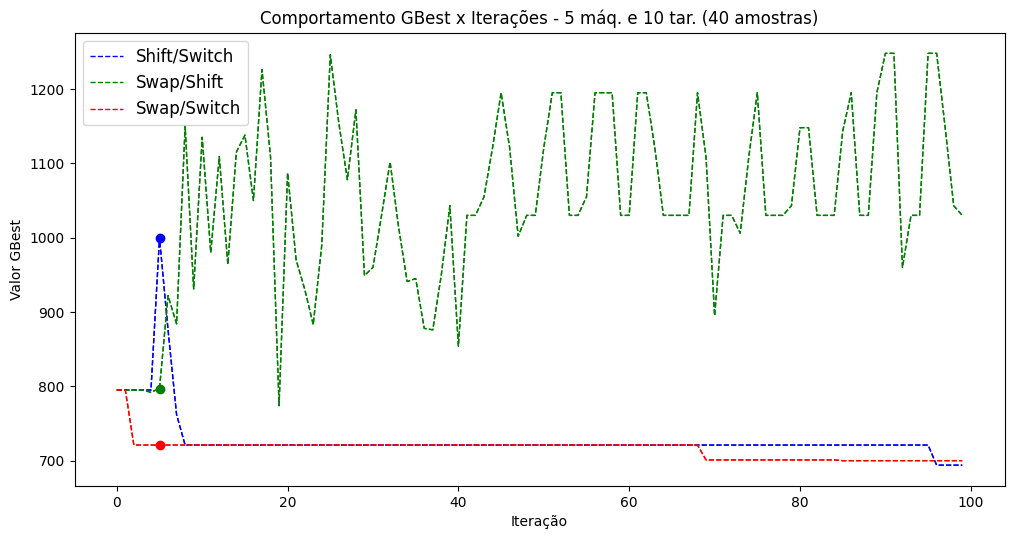

In [22]:
x = np.arange(iterations)

y_1 = bestGlobalFitnessArray[0][:]
y_2 = bestGlobalFitnessArray[1][:]
y_3 = bestGlobalFitnessArray[2][:]

fig, axes = plt.subplots(figsize=(12,6), dpi=100)

axes.plot(x, y_1, color='blue', lw=1, ls='--', label="Shift/Switch")
axes.plot(x, y_1, color='blue', lw=1, ls='--', marker='o', markevery=[iterationChoosen])

axes.plot(x, y_2, color='green', lw=1, ls='--', label="Swap/Shift")
axes.plot(x, y_2, color='green', lw=1, ls='--', marker='o', markevery=[iterationChoosen])

axes.plot(x, y_3, color='red', lw=1, ls='--', label="Swap/Switch")
axes.plot(x, y_3, color='red', lw=1, ls='--', marker='o', markevery=[iterationChoosen])

axes.set_xlabel('Iteração')
axes.set_ylabel('Valor GBest')
axes.set_title('Comportamento GBest x Iterações - {} máq. e {} tar. ({} amostras)'.format(machines, tasks, numberOfParticles))
axes.legend(fontsize=12)

## Histograma

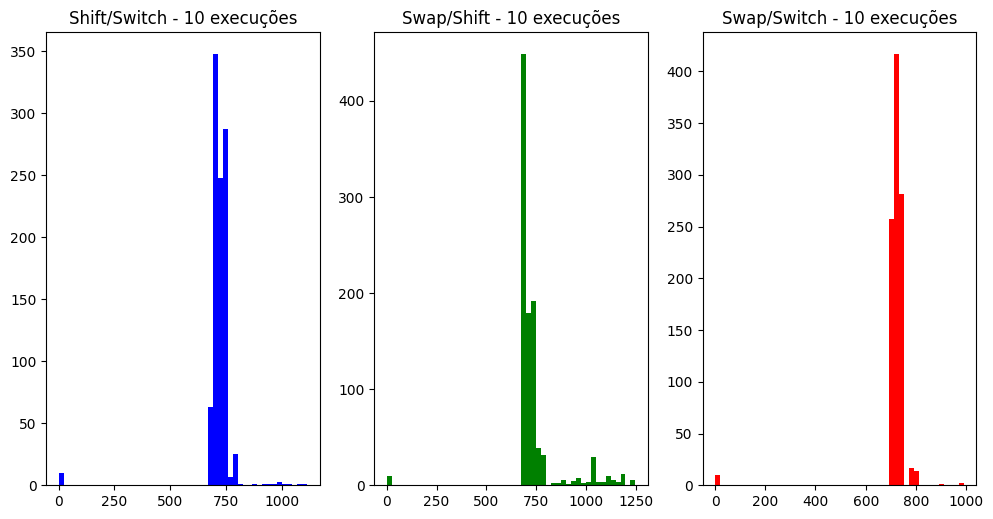

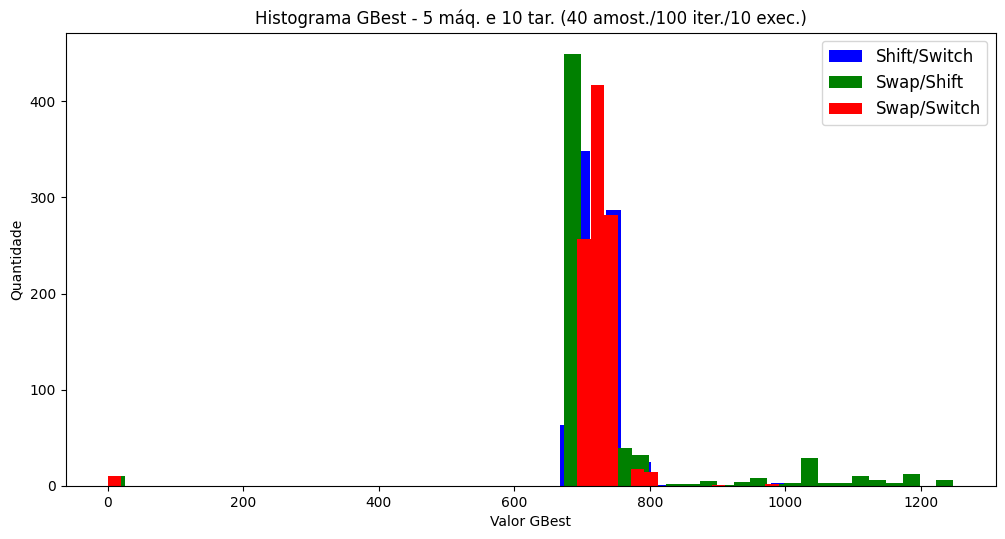

In [50]:
executionTimeArrayStore = executionTimeArrayStore.reshape(sizeNeighborhoodStructure, iterations*executionTimeQuantity)
nBins = 50

figHist, axesHist = plt.subplots(1, 3, figsize=(12,6), dpi=100)

axesHist[0].hist(executionTimeArrayStore[0,:], bins=nBins, color='blue')
axesHist[1].hist(executionTimeArrayStore[1,:], bins=nBins, color='green')
axesHist[2].hist(executionTimeArrayStore[2,:], bins=nBins, color='red')
axesHist[0].set_title('Shift/Switch - {} execuções'.format(executionTimeQuantity))
axesHist[1].set_title('Swap/Shift - {} execuções'.format(executionTimeQuantity))
axesHist[2].set_title('Swap/Switch - {} execuções'.format(executionTimeQuantity))

# Full figure
figHistComplete, axesHistComplete = plt.subplots(figsize=(12,6), dpi=100)

axesHistComplete.hist(executionTimeArrayStore[0,:], bins=nBins, color='blue', label="Shift/Switch")
axesHistComplete.hist(executionTimeArrayStore[1,:], bins=nBins, color='green', label="Swap/Shift")
axesHistComplete.hist(executionTimeArrayStore[2,:], bins=nBins, color='red', label="Swap/Switch")

axesHistComplete.set_ylabel('Quantidade')
axesHistComplete.set_xlabel('Valor GBest')
axesHistComplete.set_title('Histograma GBest - {} máq. e {} tar. ({} amost./{} iter./{} exec.)'.format(machines, tasks, numberOfParticles, iterations, executionTimeQuantity))
axesHistComplete.legend(fontsize=12)